In [13]:
import numpy as np
import math
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import linprog
from matplotlib import pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value

# Графики функции выплат

Пример 1. Постройте графики функции выплат для опционов колл (покупка, продажа) и пут (покупка, продажа).

In [4]:
def payoff_buy_call(S, K):
    return np.maximum(S - K, 0)

def payoff_buy_put(S, K):
    return np.maximum(K - S, 0)

def payoff_sell_call(S, K):
    return -payoff_buy_call(S, K)

def payoff_sell_put(S, K):
    return -payoff_buy_put(S, K)

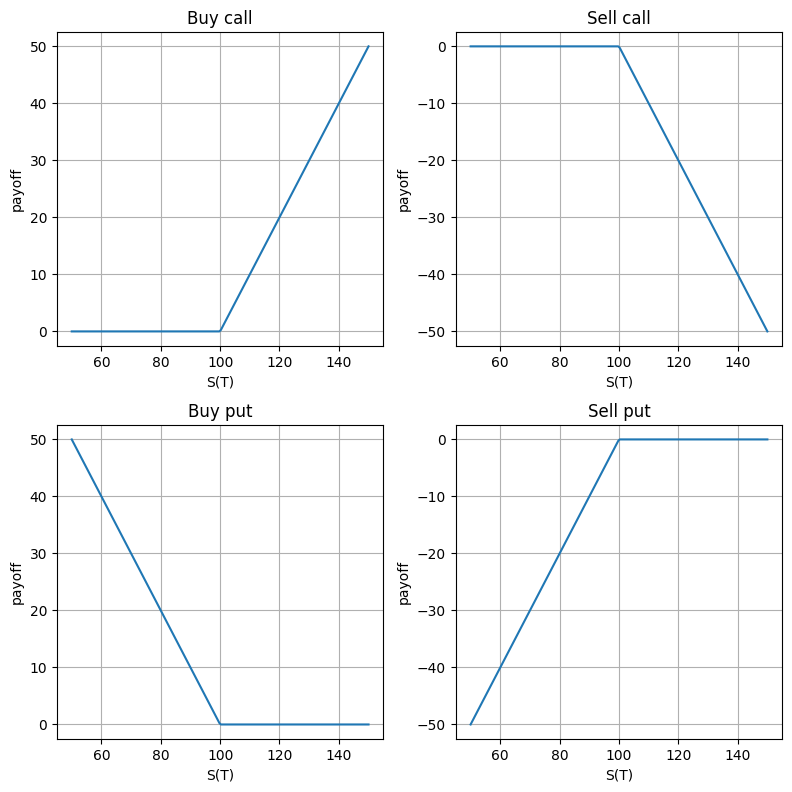

In [5]:
K = 100
S = np.linspace(50, 150, 200)

fig, ax = plt.subplots(2, 2, figsize = (8,8))
ax[0][0].plot(S, payoff_buy_call(S, K))
ax[0][0].set_xlabel("S(T)")
ax[0][0].set_ylabel("payoff")
ax[0][0].grid(True)
ax[0][0].set_title("Buy call")

ax[0][1].plot(S, payoff_sell_call(S, K))
ax[0][1].set_xlabel("S(T)")
ax[0][1].set_ylabel("payoff")
ax[0][1].grid(True)
ax[0][1].set_title("Sell call")

ax[1][0].plot(S, payoff_buy_put(S, K))
ax[1][0].set_xlabel("S(T)")
ax[1][0].set_ylabel("payoff")
ax[1][0].grid(True)
ax[1][0].set_title("Buy put")

ax[1][1].plot(S, payoff_sell_put(S, K))
ax[1][1].set_xlabel("S(T)")
ax[1][1].set_ylabel("payoff")
ax[1][1].grid(True)
ax[1][1].set_title("Sell put")

fig.tight_layout(pad=1.0)

## Задача (Collar)

  Допустим, что текущая цена базового актива равна 70.65, страйки опциона пут и колл равны 65 и 75 соответственно, а оценки их стоимости (премии) равны 2 и 3.25 соответственно. Постройте стратегию, которая заключается в покупке опциона пут и продаже опциона колл.

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии. Постройте график функции выплат для опционной стратегии.

https://blog.quantinsti.com/collar-options-trading-strategy-python/


In [17]:
# Цена базового актива
S = 70.65

# Long put
K_long_put = 65
premium_long_put = 2

# Short call
K_short_call = 75
premium_short_call = 3.25

В случае, когда пут дает выплату, мы продали актив и сравняли прибыль и убыток. В случае, когда выплатили по колу, но дорого продали свой актив, потому сравняли

Min: -4.400000000000013
Max: 5.599999999999994


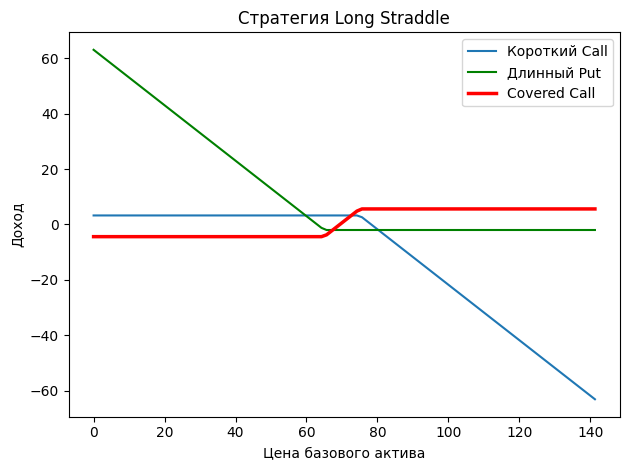

In [19]:
prices = np.linspace(0, S * 2, 100)

payoff_short_call = (np.minimum(prices, K_short_call) - prices) + premium_short_call
payoff_long_put = np.maximum(K_long_put - prices, 0) - premium_long_put
payoff_covered_call = prices - S + payoff_short_call + payoff_long_put

# Вывод минимальной и максимальной прибыли стратегии
print(f'Min: {payoff_covered_call.min()}')
print(f'Max: {payoff_covered_call.max()}')

# Построение графиков
plt.plot(prices, payoff_short_call, label='Короткий Call')
plt.plot(prices, payoff_long_put, label='Длинный Put', color='green')
plt.plot(prices, payoff_covered_call, label='Covered Call', linewidth=2.5, color='red')
plt.xlabel('Цена базового актива')
plt.ylabel('Доход')
plt.title('Стратегия Long Straddle')
plt.legend()
plt.tight_layout()
plt.show()

## Задача (Long Straddle)

Допустим, что текущая цена базового актива равна 172.5, страйки опциона пут и колл однинаковые и равны 200, а премии опционов равны 29.25 и 0.04 соответственно. Постройте стратегию, которая заключается в покупке опциона пут и покупке опциона колл.

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии. Постройте график функции выплат для опционной стратегии.

https://blog.quantinsti.com/straddle-options-trading-strategy-python/

In [20]:
# Цена базового актива
S = 172.5

# Long put
K_long_put = 200
premium_long_put = 29.25

# Long call
K_long_call = 200
premium_long_call = 0.04

Min: -27.926363636363625
Max: 170.71


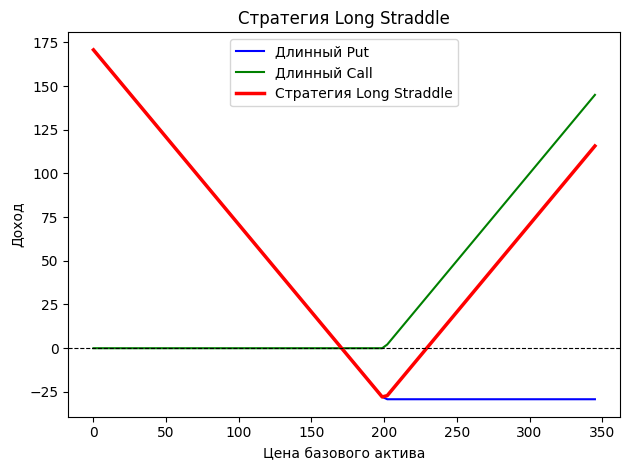

In [21]:
prices = np.linspace(0, S * 2, 100)

# Выплаты по длинному путу
payoff_long_put = np.maximum(K_long_put - prices, 0) - premium_long_put

# Выплаты по длинному коллу
payoff_long_call = np.maximum(prices - K_long_call, 0) - premium_long_call

# Общая выплата по стратегии Long Straddle
payoff_long_straddle = payoff_long_put + payoff_long_call

print(f'Min: {payoff_long_straddle.min()}')
print(f'Max: {payoff_long_straddle.max()}')

plt.plot(prices, payoff_long_put, label='Длинный Put', color='blue')
plt.plot(prices, payoff_long_call, label='Длинный Call', color='green')
plt.plot(prices, payoff_long_straddle, label='Стратегия Long Straddle', color='red', linewidth=2.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Линия уровня 0
plt.xlabel('Цена базового актива')
plt.ylabel('Доход')
plt.title('Стратегия Long Straddle')
plt.legend()
plt.tight_layout()
plt.show()

# Биноминальная модель

In [22]:
# plot_binomial_tree: visualisation of the tree and state prices
def plot_binomial_tree(statePrices):
    for i in range(0,n+1):
        for j in range(0,n+1):
            if j>i:
                break
            if i<n:
                x1, y1 = [i, i+1], [2*j-(i-1),2*j+1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="red")
                x1, y1 = [i, i+1], [2*j-(i-1),2*j-1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="black")
            plt.text(i-0.2,2*j-(i-1)-0.6,"%.2f" % statePrices["payoff"][i][j])
            plt.text(i-0.2,2*j-(i-1)-1.0,"%.2f" % statePrices["underlying"][i][j],color="blue")
    plt.title("Биноминальное дерево")
    plt.xlabel("p=%.1f%%, u=%.3f, r=%.2f%%, q=%.2f%%, dt=%.2fdays" % (statePrices["p"]*100,
                                                                   statePrices["u"],
                                                                   statePrices["r"]*100,
                                                                   statePrices["q"]*100,
                                                                   statePrices["dt"]*365))
    plt.show()

In [23]:
# binomial_tree_pricer

def binomial_tree_pricer(r, q, sigma, T, n, S, payoff, american=True, showStatePrices=False):
# r: risk neutral rate
# q: dividend yield
# sigma: volatility
# T: maturity in years
# n: number of time steps
# S: spot stock price
# payoff: payoff function e.g.: lambda S: max(S-K,0)
# american: early exercise: True if american, otherwise European
# showStatePrices: print tree probabilities and state prices

    dt = T/n
    up  = np.exp(sigma*np.sqrt(dt))
    p0 = (up * np.exp((r-q) * dt) - 1) / (up**2 - 1)
    p1 = 1 - p0
    df = np.exp(-r * dt)
    # initial values at time T
    statePrices = {"p":p0, "u":up, "r":r, "q":q, "dt":dt}
    if showStatePrices:
        statePrices["payoff"]=np.zeros((n+1,n+1))
        statePrices["underlying"]=np.zeros((n+1,n+1))
    p = np.zeros(n+1)
    for i in range(n+1): # i from 0 to n incl
        p[i] = payoff(S * up**(2*i - n))
        if showStatePrices:
            statePrices["payoff"][n][i] = p[i]
            statePrices["underlying"][n][i] = S * up**(2*i - n)
    # move to earlier times
    for j in range(n-1,-1,-1): # j from n-1 to 0 incl
        for i in range(j+1): # i from 0 to j incl
            # discounted expected value of exdiv price
            p[i] = (p0 * p[i+1] + p1 * p[i])*df
            # american payoff
            if american:
                early_exercise = payoff(S * up**(2*i - j))
                p[i] = max(early_exercise,p[i])
            if showStatePrices:
                statePrices["payoff"][j][i] = p[i]
                statePrices["underlying"][j][i] = S * up**(2*i - j)
    if showStatePrices:
        plot_binomial_tree(statePrices)
    return p[0]

Пример. Текущая цена акций равна 50, волатильность 15%, цена страйк на 1% выше цены базового актива, время до экспирации 1 месяц, безрисковая ставка 5%, на акции начисляются дивиденды 2%. Постройте биноминальное дерево на 5 периодов для европейского опциона пут и оцените его стоимость.

Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)


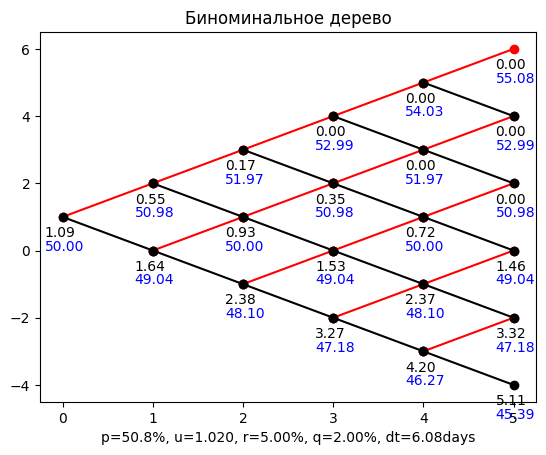

np.float64(1.0853174417962133)

In [24]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(K-S,0), american=False, showStatePrices=True)

## Задача (дерево)

Задача. Постройте биноминальные деревья для
*   американского опциона колл,
*   американского опциона пут,
*   европейского опциона колл,
*   европейского опциона пут
и сделайте выводы.





In [30]:
r, q, sigma, T, n, S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S * 1.01 

Биноминальное дерево, американский опцион колл, функция выплат max(S-K, 0)


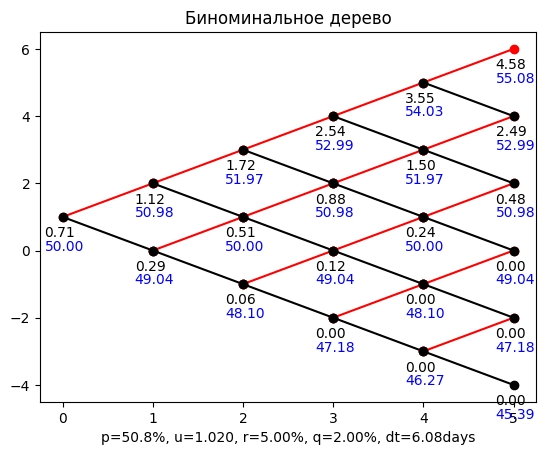

np.float64(0.7120324211650718)

In [26]:
# Американский опцион колл
print("Биноминальное дерево, американский опцион колл, функция выплат max(S-K, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(S - K, 0), american=True, showStatePrices=True)

Биноминальное дерево, американский опцион пут, функция выплат max(K-S, 0)


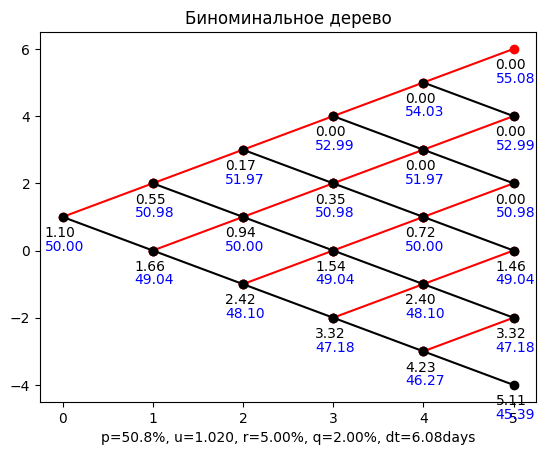

np.float64(1.0962783164249443)

In [27]:
# Американский опцион пут
print("Биноминальное дерево, американский опцион пут, функция выплат max(K-S, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(K - S, 0), american=True, showStatePrices=True)

Биноминальное дерево, европейский опцион колл, функция выплат max(S-K, 0)


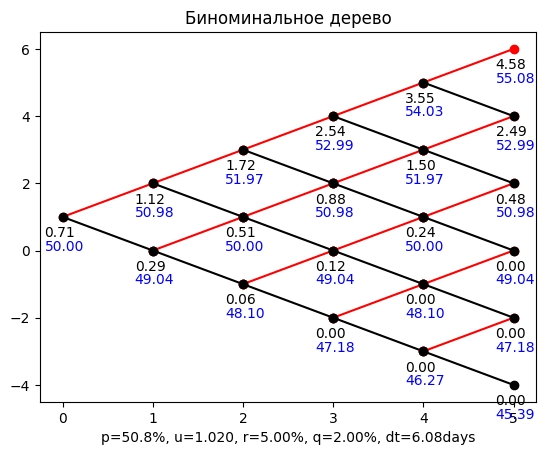

np.float64(0.7120324211650718)

In [28]:
# Европейский опцион колл
print("Биноминальное дерево, европейский опцион колл, функция выплат max(S-K, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(S - K, 0), american=False, showStatePrices=True)

Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)


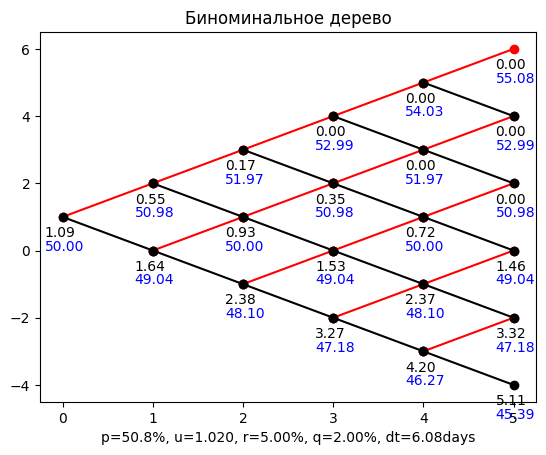

np.float64(1.0853174417962133)

In [29]:
# Европейский опцион пут
print("Биноминальное дерево, европейский опцион пут, функция выплат max(K-S, 0)")
binomial_tree_pricer(r, q, sigma, T, n, S, lambda S: max(K - S, 0), american=False, showStatePrices=True)

# Модель Блека-Шоулза

Задача. Допустим, что условия модели Блека-Шоулза выполнены. Текущая цена бездивидентных акций равна 100, волатальность
5%, цена страйк 100, время до экспирации один год, безрисковая
ставка 5%.

Оцените справедливую стоимость опционов колл и пут и вычислите греческие характеристики для опционов как функцию от текущей цены базового актива.

In [5]:
r = 0.07
T = 1
K = 100
S0 = 100
sigma = 0.3
t = 0
q = 0
tau = T - t

## Задача (оценка и паритет)

In [6]:
# оценка опциона колл
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

In [7]:
# оценка опциона пут
def put(S, K, T, sigma, r, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

In [8]:
# оценка опциона пут с использованием паритета
def put_paritet(S, K, T, sigma, r, q):
    return call(S, K, T, sigma, r, q) + K * np.exp(-r * T) - S

Сравните результаты оценки опциона пут с/без паритета цен

In [9]:
# Оценка опционов и сравнение
params = f"r = {r}, sigma = {sigma}, t = {t}, T = {T}, S0 = {S0}, K = {K}"
print("Параметры:", params)

call_price = call(S0, K, tau, sigma, r, q)
put_price = put(S0, K, tau, sigma, r, q)
put_price_parity = put_paritet(S0, K, tau, sigma, r, q)

print(f"Оценка опциона колл: {call_price:.4f}")
print(f"Оценка опциона пут: {put_price:.4f}")
print(f"Оценка опциона пут (через паритет): {put_price_parity:.4f}")

Параметры: r = 0.07, sigma = 0.3, t = 0, T = 1, S0 = 100, K = 100
Оценка опциона колл: 15.2105
Оценка опциона пут: 8.4499
Оценка опциона пут (через паритет): 8.4499


In [10]:
params = f"r = {r}, sigma = {sigma}, t = {t}, T = {T}, S0 = {S0}, K = {K}"
print('Параметры:', params)

call_price = call(S0, K, T, sigma, r, q)
print('Оценка опциона колл =', call_price)
put_price  =  put(S0, K, T, sigma, r, q)
print('Оценка опциона пут =', put_price)

Параметры: r = 0.07, sigma = 0.3, t = 0, T = 1, S0 = 100, K = 100
Оценка опциона колл = 15.210500635727158
Оценка опциона пут = 8.449882626321987


## Задача (греческие характеристики)

Вспомогательные функции для аналитического вычисления греческих характеристик.

In [36]:
def greeks(S0, K, tau, sigma, r, q, option_type="call"):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    put_price = K * np.exp(-r * tau) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    delta = norm.cdf(d1) if option_type == "call" else -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(tau))
    theta = (-S0 * sigma * norm.pdf(d1) / (2 * np.sqrt(tau)) 
             - r * K * np.exp(-r * tau) * norm.cdf(d2 if option_type == "call" else -d2))
    kappa = -np.exp(-r * T) * norm.cdf(d2 if option_type == "call" else -d2)
    vega = S0 * np.sqrt(tau) * norm.pdf(d1)
    rho = K * tau * np.exp(-r * tau) * norm.cdf(d2 if option_type == "call" else -d2)
    
    return {
        "delta": delta, 
        "gamma": gamma, 
        "theta": theta, 
        "kappa": kappa,
        "vega": vega, 
        "rho": rho
    }

def greeks2(S0, K, tau, r, sigma, option_type="call"):
    d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    put_price = K * np.exp(-r * tau) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(tau))

    if option_type=="call":
        delta = norm.cdf(d1)
        theta = (-S0 * norm.pdf(d1) * sigma / (2 * np.sqrt(tau))
                  - r * K * np.exp(-r * tau) * norm.cdf(d2))
        rho = K * tau * np.exp(-r * tau) * norm.cdf(d2)
        kappa = -np.exp(-r * T)*norm.cdf(d2) 
    else:
        delta = norm.cdf(d1) - 1
        theta = (-S0 * norm.pdf(d1) * sigma / (2 * np.sqrt(tau))
                 + r * K * np.exp(-r * tau) * norm.cdf(-d2))
        rho = -K * tau * np.exp(-r * tau) * norm.cdf(-d2)
        kappa = np.exp(-r * T) * norm.cdf(-d2)
    
    vega = S0 * np.sqrt(tau) * norm.pdf(d1)
    
    return {
        "call_price": call_price,
        "put_price": put_price,
        "delta": delta,
        "gamma": gamma,
        "theta": theta,
        "kappa": kappa,
        "vega": vega,
        "rho": rho,
    }

Графики зависимости греческих характеристик для опционов от цены базового актива.

In [15]:
# Сравнение греков
call_greeks = greeks(S0, K, tau, sigma, r, q, option_type="call")
put_greeks = greeks(S0, K, tau, sigma, r, q, option_type="put")

print("\nГреки для колл-опциона:")
for greek, value in call_greeks.items():
    print(f"{greek}: {value:.4f}")

print("\nГреки для пут-опциона:")
for greek, value in put_greeks.items():
    print(f"{greek}: {value:.4f}")


Греки для колл-опциона:
delta: 0.5987
gamma: 0.0193
theta: -6.3396
kappa: -0.4946
vega: 38.6668
rho: 49.4581

Греки для пут-опциона:
delta: -0.4013
gamma: 0.0193
theta: -6.1499
kappa: -0.4566
vega: 38.6668
rho: 45.6648


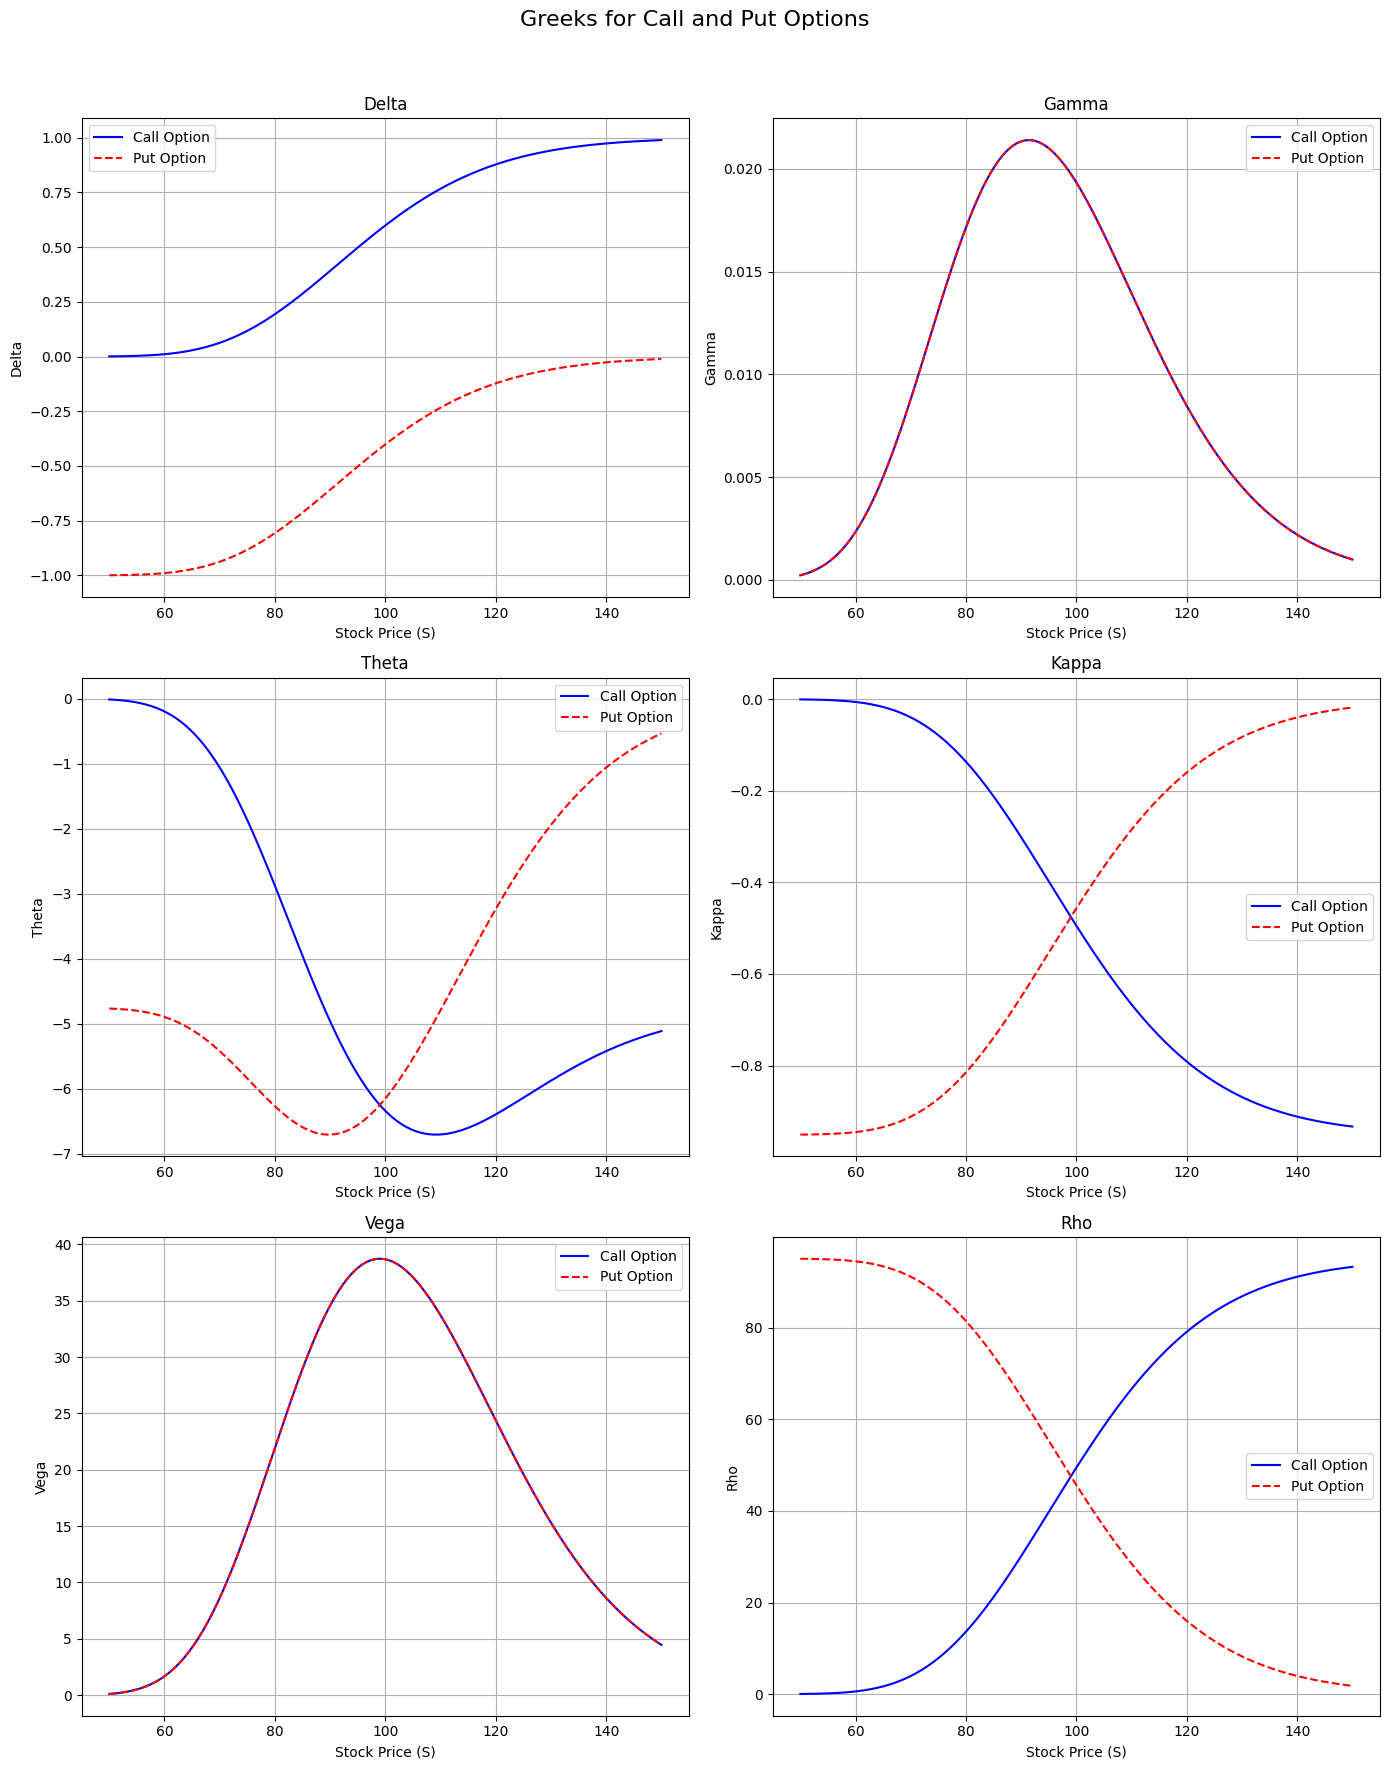

In [37]:
S0 = 100  # Initial stock price
K = 100   # Strike
T = 1     
sigma = 0.2  # Volatility
r = 0.05  # Risk-free rate
q = 0.02  # Dividend yield

N = 1000
S_range = np.linspace(S0 * 0.5, S0 * 1.5, N)
call_greeks = {greek: [] for greek in ["delta", "gamma", "theta", "kappa", "vega", "rho"]}
put_greeks = {greek: [] for greek in ["delta", "gamma", "theta", "kappa", "vega", "rho"]}

for S in S_range:
    for greek, value in greeks(S, K, T, sigma, r, q, option_type="call").items():
        call_greeks[greek].append(value)
    for greek, value in greeks(S, K, T, sigma, r, q, option_type="put").items():
        put_greeks[greek].append(value)

fig, axs = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle("Greeks for Call and Put Options", fontsize=16)

for i, greek in enumerate(call_greeks.keys()):
    ax = axs[i // 2, i % 2]
    ax.plot(S_range, call_greeks[greek], label="Call Option", color="blue")
    ax.plot(S_range, put_greeks[greek], label="Put Option", color="red", linestyle="dashed")
    ax.set_title(greek.capitalize())
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel(greek.capitalize())
    ax.legend()
    ax.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Задача. Вычислите греческие коэффициенты численно и сравните результаты.

```
def first_derivative(f, x, h=0.001):
    return (f(x + h) - f(x - h)) / (2 * h)

def second_derivative(f, x, h=0.001):
    return (f(x + h) - 2 * f(x) + f(x - h)) / (h * h)
```




In [19]:
def d1(S, K, r, T, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, r, T, sigma):
    return d1(S, K, r, T, sigma) - sigma * np.sqrt(T)

def call_price(S, K, r, T, sigma):
    return S * norm.cdf(d1(S, K, r, T, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, T, sigma))

def put_price(S, K, r, T, sigma):
    return K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, T, sigma)) - S * norm.cdf(-d1(S, K, r, T, sigma))

# Численные приближения греков
def numerical_delta(S, K, r, T, sigma, option, h=1e-3):
    return (option(S + h, K, r, T, sigma) - option(S - h, K, r, T, sigma)) / (2 * h)

def numerical_gamma(S, K, r, T, sigma, option, h=1e-3):
    return (option(S + h, K, r, T, sigma) - 2 * option(S, K, r, T, sigma) + option(S - h, K, r, T, sigma)) / (h ** 2)

def numerical_vega(S, K, r, T, sigma, option, h=1e-3):
    return (option(S, K, r, T, sigma + h) - option(S, K, r, T, sigma - h)) / (2 * h)

def numerical_theta(S, K, r, T, sigma, option, h=1e-3):
    return (option(S, K, r, T - h, sigma) - option(S, K, r, T + h, sigma)) / (2 * h)

def numerical_rho(S, K, r, T, sigma, option, h=1e-3):
    return (option(S, K, r + h, T, sigma) - option(S, K, r - h, T, sigma)) / (2 * h)

def numerical_kappa(S, K, r, T, sigma, option, h=1e-3):
    return (option(S, K + h, r, T, sigma) - option(S, K - h, r, T, sigma)) / (2 * h)

analytical = greeks(S, K, T, sigma, r, q, option_type="call")
numerical = {
    "delta": numerical_delta(S, K, r, T, sigma, call_price),
    "gamma": numerical_gamma(S, K, r, T, sigma, call_price),
    "vega": numerical_vega(S, K, r, T, sigma, call_price),
    "theta": numerical_theta(S, K, r, T, sigma, call_price),
    "rho": numerical_rho(S, K, r, T, sigma, call_price),
}

print("Греки для колл-опциона:")
for greek, value in analytical.items():
    if greek in numerical:  # Сравниваем только те греки, которые есть в численных вычислениях
        print(f"{greek.capitalize()}: Аналитическое = {value:.6f}, Численное = {numerical[greek]:.6f}")

Греки для колл-опциона:
Delta: Аналитическое = 0.988617, Численное = 0.991281
Gamma: Аналитическое = 0.000995, Численное = 0.000788
Theta: Аналитическое = -5.113862, Численное = -5.040711
Vega: Аналитическое = 4.475379, Численное = 3.546301
Rho: Аналитическое = 93.326473, Численное = 93.721936


Задача. Постройте график трехмерной поверхности для описания зависимости греческих коэффициентов опциона  
*   кол,
*   пут

от стоимости базового актива и
количества дней до экспирации.

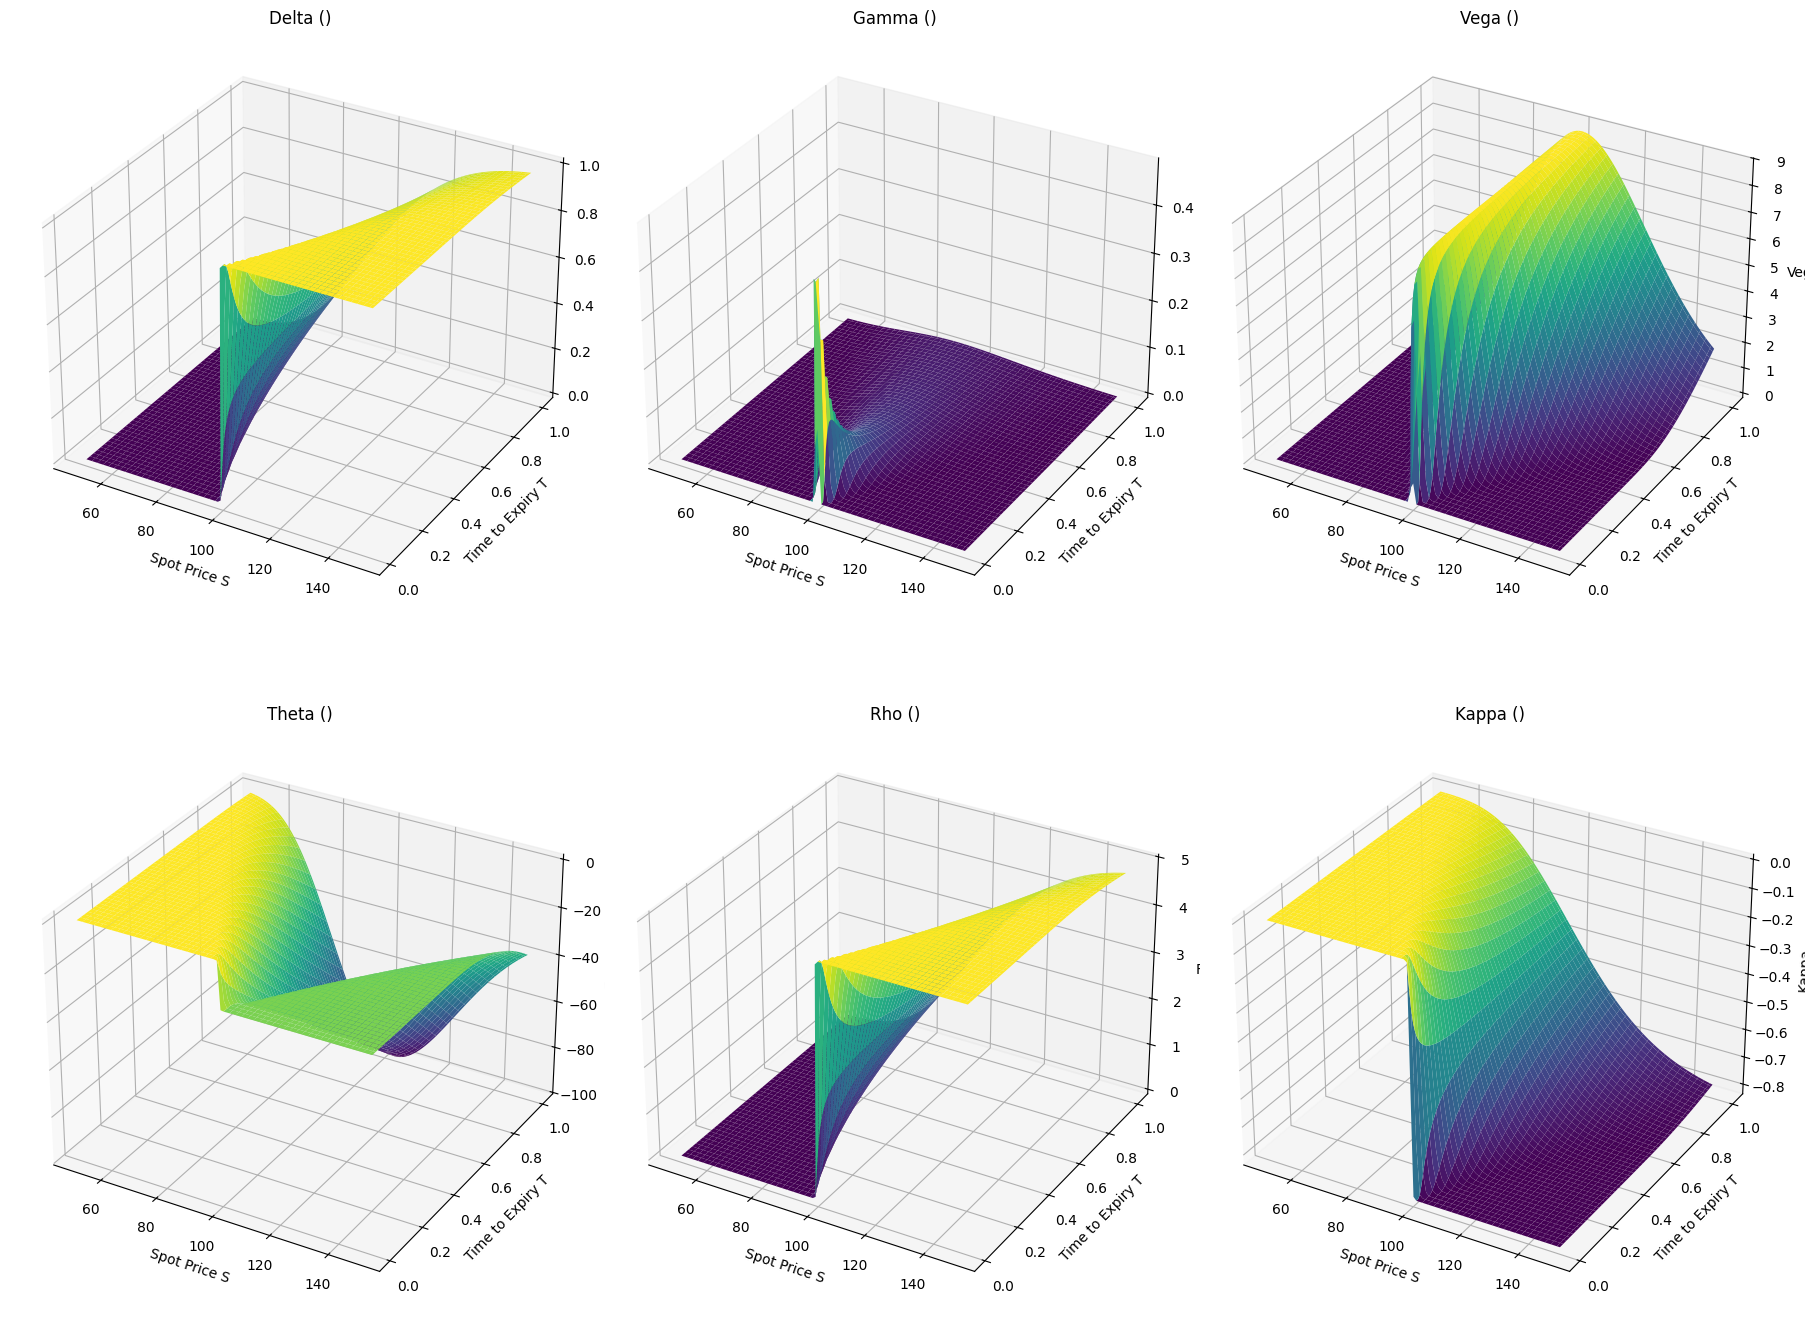

In [45]:
K = 100  
r = 0.05 
sigma = 0.2

S0_range = np.linspace(50, 150, 100)
T0_range = np.linspace(0.01, 1, 100)

S_grid, T_grid = np.meshgrid(S0_range, T0_range)

fig = plt.figure(figsize=(18, 15))

for i, greek_name in enumerate(['delta', 'gamma', 'vega', 'theta', 'rho', 'kappa']):

        results = greeks2(S_grid, K, r, sigma, T_grid, option_type="call")
        
        if greek_name == 'delta':
            Z = results['delta']
        elif greek_name == 'gamma':
            Z = results['gamma']
        elif greek_name == 'vega':
            Z = results['vega']
        elif greek_name == 'theta':
            Z = results['theta']
        elif greek_name == 'rho':
            Z = results['rho']
        elif greek_name == 'kappa':
            Z = results['kappa']

        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        ax.plot_surface(S_grid, T_grid, Z, cmap='viridis')
        ax.set_title(f'{greek_name.capitalize()} ()')
        ax.set_xlabel('Spot Price S')
        ax.set_ylabel('Time to Expiry T')
        ax.set_zlabel(greek_name.capitalize())

plt.tight_layout()
plt.show()

# Опционная стратегия

## Задача (по вариантам)

Задача. С использование досок опционов [Nasdaq](https://www.nasdaq.com/market-activity/stocks/aapl/option-chain) или [MOEX](https://www.moex.com/ru/derivatives/optionsdesk.aspx) выберите ликвидный актив и реализуейте две [опционных стратегий](https://www.option.ru/glossary/strategy),
$i$ и $i+12$, где $i$ -- ваша фамилия по алфавиту:

1.   Покупка опциона колл. Long Call
1. Продажа опциона колл. Short Call
1. Покупка опциона пут. Long Put
1. Продажа опциона пут. Short Put
1. Бычий колл спрэд. Bull Call Spread
1. Бычий пут спрэд. Bull Put Spread
1. Медвежий колл спрэд. Bear Call Spread
1. Медвежий пут спрэд. Bear Put Spread
1. Покупка бабочки. Long Butterfly
1. Продажа бабочки. Short Butterfly
1. Покупка кондора. Long Condor
1. Продажа кондора. Short Condor
1. Покупка стрэддла. Long Straddle
1. Продажа стрэддла. Short Straddle
1. Покупка стрэнгла. Long Strangle
1. Продажа стрэнгла. Short Strangle
1. Пропорциональный колл спрэд. Call Ratio Spread
1. Пропорциональный пут спрэд. Put Ratio Spread
1. Пропорциональный обратный колл спрэд. Call Ratio Backspread
1. Пропорциональный обратный пут спрэд. Put Ratio Backspread
1. Синтетический длинный фьючерс. Synthetic Long Futures
1. Синтетический короткий фьючерс. Synthetic Short Futures
1. Стрэп. Strap
1. Стрип. Strip
1. Обратный бычий спрэд. Bull Backspread
1. Обратный медвежий спрэд. Bear Backspread

Проанализируйте как влияет соотношение  спот цены базового актива $S$ и цены страйк $K$ для

опциона call:

*   $S > K$ -- в деньгах (in the money),   
*   $S = K$ -- около денег (at the money),
*   $S < K$ --  вне денег (out of the money) и

опциона put:
*   $S < K$ -- в деньгах (in the money),
*   $S = K$ -- около денег (at the money),  
*   $S > K$ -- вне денег (out of the money).

Определите максимальную прибыль и потери, если цена базового актива может вырасти в два раза (меньше нуля не может быть). Определите интервал безубыточности стратегии с учетом премии.

Постройте график функции выплат для каждой опционной стратегии.

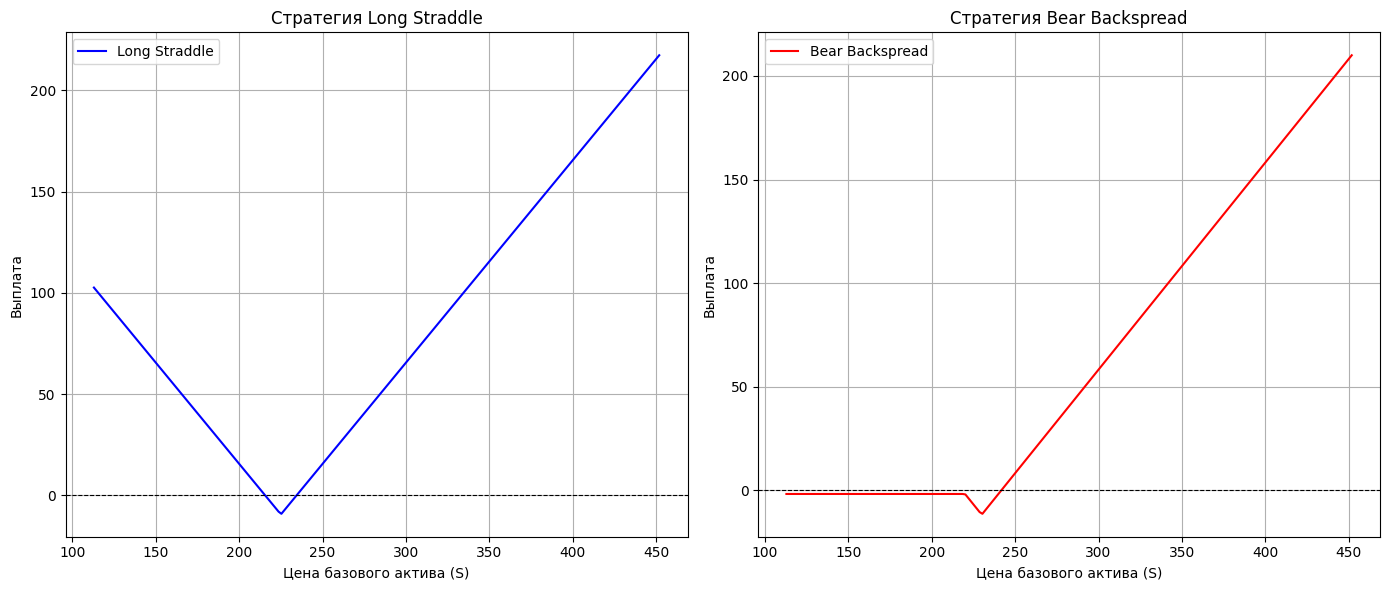

Long Straddle:
Максимальная прибыль: Неограниченная
Максимальный убыток: -9.399999999999999
Точки безубыточности: (215.60, 234.40)

Bear Backspread:
Максимальная прибыль: 0.00
Максимальный убыток: 1.78
Точка безубыточности: 218.22


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
spot_price = 225.89  # Текущая цена базового актива
S = np.linspace(spot_price * 0.5, spot_price * 2, 200)  # Цены актива от 0.5x до 2x

# Long Straddle
K_straddle = 225.0  # Страйк опциона
premium_call = 4.3  # Премия за колл-опцион
premium_put = 5.1  # Премия за пут-опцион

payoff_call = np.maximum(S - K_straddle, 0) - premium_call  # Выплата колл-опциона
payoff_put = np.maximum(K_straddle - S, 0) - premium_put  # Выплата пут-опциона
payoff_straddle = payoff_call + payoff_put  # Выплата стратегии

# Bear Backspread
K1_backspread = 220.0  # Меньший страйк
K2_backspread = 230.0  # Больший страйк
premium_call_short = 10.32  # Премия за продажу колл-опциона (меньший страйк)
premium_call_long = 6.05  # Премия за покупку колл-опциона (больший страйк)

payoff_short_call = -np.maximum(S - K1_backspread, 0) + premium_call_short  # Выплата проданного колл-опциона
payoff_long_call = 2 * (np.maximum(S - K2_backspread, 0) - premium_call_long)  # Выплата двух купленных колл-опционов
payoff_backspread = payoff_short_call + payoff_long_call  # Выплата стратегии

# Графики
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# График Long Straddle
ax[0].plot(S, payoff_straddle, label="Long Straddle", color="blue")
ax[0].axhline(0, color="black", linestyle="--", linewidth=0.8)
ax[0].set_title("Стратегия Long Straddle")
ax[0].set_xlabel("Цена базового актива (S)")
ax[0].set_ylabel("Выплата")
ax[0].legend()
ax[0].grid()

# График Bear Backspread
ax[1].plot(S, payoff_backspread, label="Bear Backspread", color="red")
ax[1].axhline(0, color="black", linestyle="--", linewidth=0.8)
ax[1].set_title("Стратегия Bear Backspread")
ax[1].set_xlabel("Цена базового актива (S)")
ax[1].set_ylabel("Выплата")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

# Анализ выплат

# Long Straddle
max_profit_straddle = "Неограниченная"  # При значительном движении цены
max_loss_straddle = -(premium_call + premium_put)  # Сумма премий
breakeven_straddle_low = K_straddle - (premium_call + premium_put)
breakeven_straddle_high = K_straddle + (premium_call + premium_put)

print("Long Straddle:")
print(f"Максимальная прибыль: {max_profit_straddle}")
print(f"Максимальный убыток: {max_loss_straddle}")
print(f"Точки безубыточности: ({breakeven_straddle_low:.2f}, {breakeven_straddle_high:.2f})")

# Bear Backspread
max_profit_backspread = max(
    2 * (spot_price - K2_backspread) - premium_call_long * 2 + premium_call_short,
    0
)  # При значительном росте
max_loss_backspread = -(premium_call_short - 2 * premium_call_long)  # В промежутке между страйками
breakeven_backspread = K1_backspread + (premium_call_short - 2 * premium_call_long)

print("\nBear Backspread:")
print(f"Максимальная прибыль: {max_profit_backspread:.2f}")
print(f"Максимальный убыток: {max_loss_backspread:.2f}")
print(f"Точка безубыточности: {breakeven_backspread:.2f}")


## Задача (оптимальный набор)

Задача. С использование доски опционов [Nasdaq](https://www.nasdaq.com/market-activity/stocks/aapl/option-chain) найдите оптимальный набор опционных контрактов $$
X=\{X_c, X_p\},
$$
где
$$
X_c=\{x_i^c \in
\mathbb{Z}: L\le x_i^c \le U, i \in I\},
$$
$$
X_p=\{x_i^p
\in \mathbb{Z}: L \le x_i^p \le U, i \in I\},
$$
здесь
$x_i^c$, $x_i^p>0$ -- количество опционов колл и пут для покупки, $x_i^c$, $x_i^p<0$ -- для продажи. Если
$x_i^c=0$ или $x_i^p=0$, то $i$-ый контракт
не входит в портфель, $L<0$ и $U>0$ -- нижняя и верхняя границы количества контрактов в портфеле соответственно,
$I=\{1,2, \ldots, n\}$ -- набор индексов.

При разработке стратегии придерживаться следующих преположений
*   покупки и продажи опционов можно осуществлять по ask- и bid-ценам,
*   можно занимать короткие и длинные позиции с учетом ликвидности контракта,
*  стратегия должна иметь защиту от падения и роста цен страйк на $x$\% от стоимости базового актива в момент времени $T$,
*  максимальный убыток стратегии ограничен величиной $\mathcal{L}$, равной $y$% от стоимости базового актива в момент времени $t=0$
*  стратегия имеет начальную стоимость $C(t,X)$, равную $w$ условных единиц капитала.

https://arxiv.org/pdf/1707.02087

Оптимальный набор контрактов:
Количества колл-опционов: [10.0, 9.5, -10.0, -10.0, -10.0]
Количества пут-опционов: [-10.0, -10.0, -10.0, -10.0, -3.0]
Минимальная стоимость портфеля: -681.5


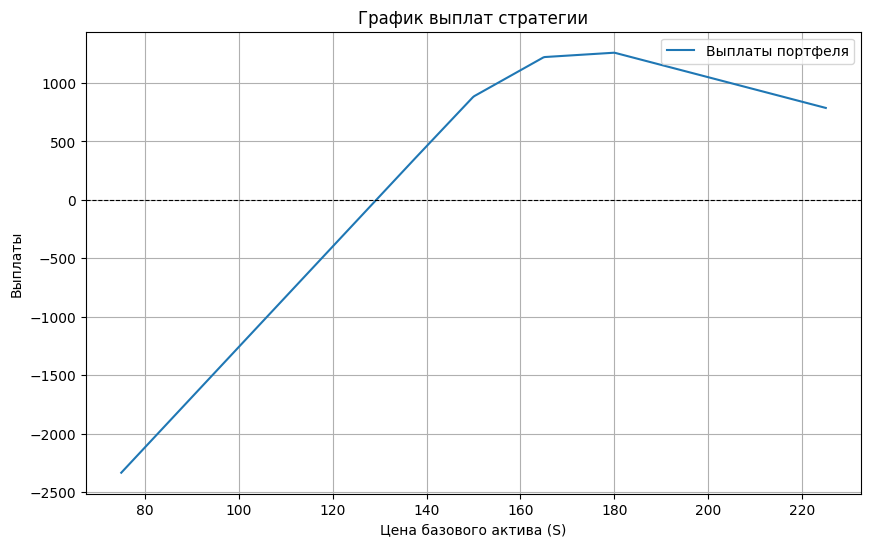

In [14]:
# Шаг 1: Данные
symbol = "AAPL"
current_price = 150  # Пример текущей цены
strike_prices = np.linspace(current_price * 0.8, current_price * 1.2, 5)  # Страйки ±20% от текущей цены
call_ask_prices = [5, 7, 10, 12, 15]  # Цена Ask для колл-опционов
put_ask_prices = [6, 8, 11, 13, 16]   # Цена Ask для пут-опционов

price_movement_percentage = 0.1  # Защита от изменения цены на 10%
max_loss_percentage = 0.2  # Максимальный убыток 20%
contract_limit_lower = -10  # Нижняя граница количества контрактов
contract_limit_upper = 10  # Верхняя граница количества контрактов
max_portfolio_value = 1000  # Начальная стоимость портфеля

price_up = current_price * (1 + price_movement_percentage)
price_down = current_price * (1 - price_movement_percentage)

# Шаг 2: Определение задачи оптимизации
problem = LpProblem("Portfolio_Optimization", LpMinimize)

# Переменные: количества опционов (колл и пут)
call_quantities = [LpVariable(f"x_call_{i}", lowBound=contract_limit_lower, upBound=contract_limit_upper, cat="Continuous") 
                   for i in range(len(strike_prices))]
put_quantities = [LpVariable(f"x_put_{i}", lowBound=contract_limit_lower, upBound=contract_limit_upper, cat="Integer") 
                  for i in range(len(strike_prices))]

# Шаг 3: Целевая функция (стоимость портфеля)
cost = lpSum([call_quantities[i] * call_ask_prices[i] + put_quantities[i] * put_ask_prices[i] 
              for i in range(len(strike_prices))])
problem += cost, "Total_Cost"

# Шаг 4: Ограничения
# Ограничение на защиту от роста и падения цен
problem += lpSum([call_quantities[i] * max(price_up - strike_prices[i], 0) + 
                  put_quantities[i] * max(strike_prices[i] - price_down, 0) 
                  for i in range(len(strike_prices))]) == 0, "Hedging"

# Ограничение на максимальный убыток
problem += lpSum([call_quantities[i] * (max(price_down - strike_prices[i], 0) - call_ask_prices[i]) +
                  put_quantities[i] * (max(strike_prices[i] - price_up, 0) - put_ask_prices[i]) 
                  for i in range(len(strike_prices))]) >= -current_price * max_loss_percentage, "Max_Loss"

# Шаг 5: Решение задачи
problem.solve()

# Проверка решения
if problem.status == 1:
    print("Оптимальный набор контрактов:")
    print("Количества колл-опционов:", [value(var) for var in call_quantities])
    print("Количества пут-опционов:", [value(var) for var in put_quantities])
    print("Минимальная стоимость портфеля:", value(problem.objective))
else:
    print("Оптимизация не удалась.")

# Шаг 6: Построение графика выплат
price_range = np.linspace(current_price * 0.5, current_price * 1.5, 500)

def calculate_payoff(price, strikes, call_quantities, put_quantities, call_prices, put_prices):
    total_payoff = np.zeros_like(price)
    for i, strike in enumerate(strikes):
        total_payoff += call_quantities[i] * (np.maximum(price - strike, 0) - call_prices[i])
        total_payoff += put_quantities[i] * (np.maximum(strike - price, 0) - put_prices[i])
    return total_payoff

call_q = [value(var) for var in call_quantities]
put_q = [value(var) for var in put_quantities]

payoff_values = calculate_payoff(price_range, strike_prices, call_q, put_q, call_ask_prices, put_ask_prices)

plt.figure(figsize=(10, 6))
plt.plot(price_range, payoff_values, label="Выплаты портфеля")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("Цена базового актива (S)")
plt.ylabel("Выплаты")
plt.title("График выплат стратегии")
plt.grid()
plt.legend()
plt.show()
